1. Importar librerías y configuraciones

In [ ]:
# === Punto 1: Importaciones y configuración ===
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from unicodedata import normalize
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import ConvergenceWarning

from xgboost import XGBClassifier
from sentence_transformers import SentenceTransformer
import spacy

# Visualización
sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 5)

# Cargar modelo spaCy (si aplica lematización)
nlp = spacy.load("es_core_news_sm")

2. Cargar, balancear y analizar distribución


=== Distribución original de etiquetas ===
label
5    109816
4     42232
3     15261
2      4833
1      4050
Name: count, dtype: int64


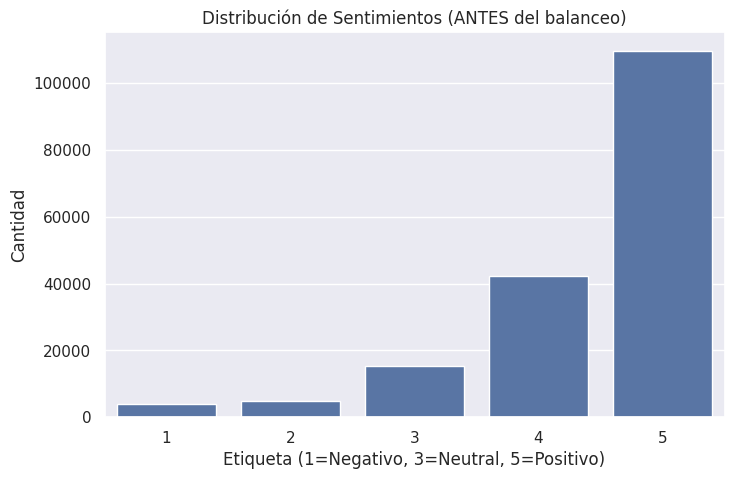

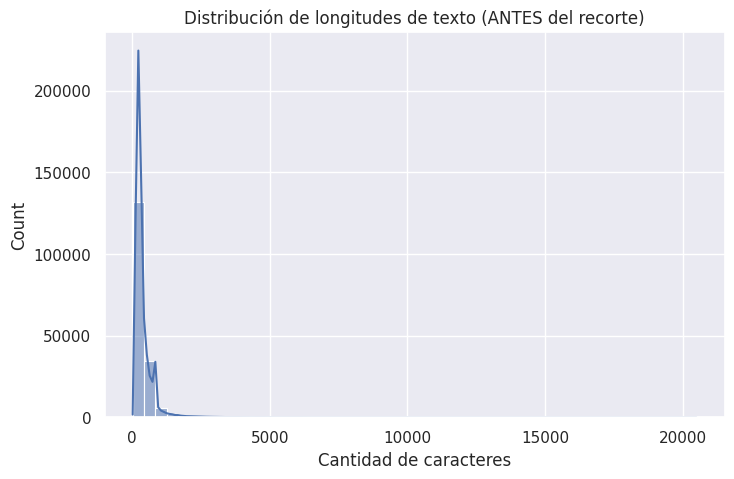


=== Percentiles de longitud de texto ===
0.25     199.0
0.50     276.0
0.75     430.0
0.95     855.0
0.99    1959.0
Name: longitud, dtype: float64

Recorte aplicado: textos > 855 caracteres eliminados

=== Distribución de etiquetas (DESPUÉS del balanceo) ===
label
4    15000
5    15000
3    14377
2     4425
1     3730
Name: count, dtype: int64


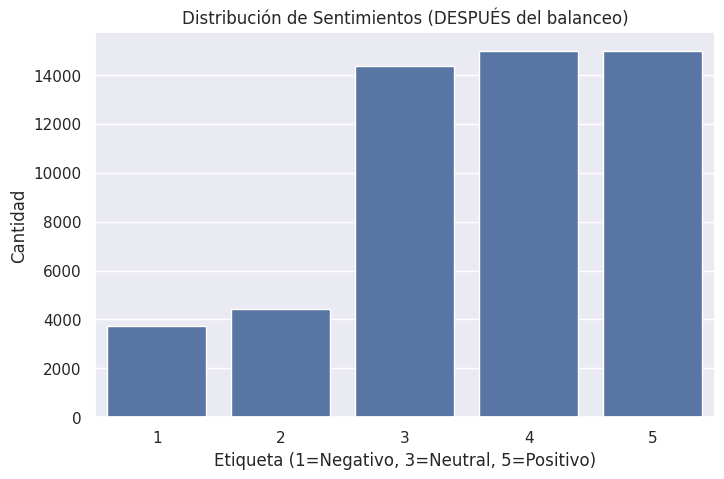

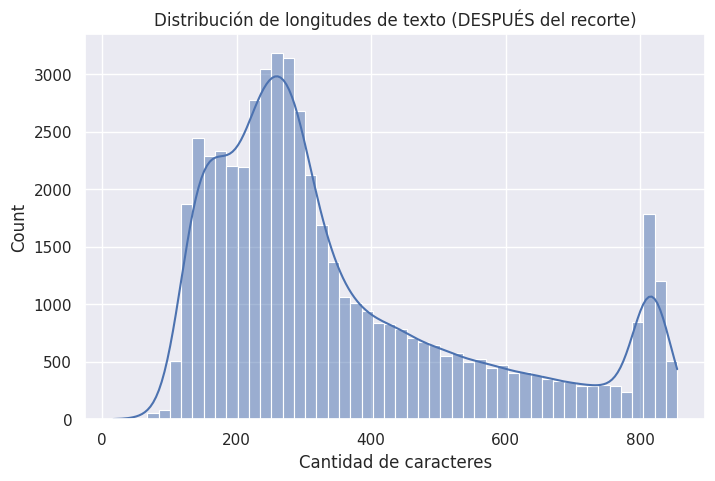

In [21]:
# 1. Cargar dataset
df_train = pd.read_parquet("/home/carizac/documnetos/proyecto_nlp/train-00000-of-00001-40d9940488cb84b1.parquet")

# 2. Visualización original (ANTES)
print("\n=== Distribución original de etiquetas ===")
print(df_train["label"].value_counts())

sns.countplot(data=df_train, x='label')
plt.title("Distribución de Sentimientos (ANTES del balanceo)")
plt.xlabel("Etiqueta (1=Negativo, 3=Neutral, 5=Positivo)")
plt.ylabel("Cantidad")
plt.show()

# Distribución de longitud
df_train["longitud"] = df_train["text"].apply(len)

sns.histplot(df_train["longitud"], bins=50, kde=True)
plt.title("Distribución de longitudes de texto (ANTES del recorte)")
plt.xlabel("Cantidad de caracteres")
plt.show()

# Calcular percentiles de longitud
percentiles = df_train["longitud"].quantile([0.25, 0.5, 0.75, 0.95, 0.99])
print("\n=== Percentiles de longitud de texto ===")
print(percentiles)

# Recorte de textos muy largos (P95)
long_max = df_train["longitud"].quantile(0.95)
df_train = df_train[df_train["longitud"] <= long_max]

print(f"\nRecorte aplicado: textos > {long_max:.0f} caracteres eliminados")

# 3. Balanceo: recortar clases 4 y 5 a 15.000
df_4 = df_train[df_train["label"] == 4].sample(n=15000, random_state=42)
df_5 = df_train[df_train["label"] == 5].sample(n=15000, random_state=42)
df_rest = df_train[~df_train["label"].isin([4,5])]

# Combinar
df_train_bal = pd.concat([df_4, df_5, df_rest], ignore_index=True).sample(frac=1, random_state=42)

# 4. Visualizaciones DESPUÉS
print("\n=== Distribución de etiquetas (DESPUÉS del balanceo) ===")
print(df_train_bal["label"].value_counts())

sns.countplot(data=df_train_bal, x='label')
plt.title("Distribución de Sentimientos (DESPUÉS del balanceo)")
plt.xlabel("Etiqueta (1=Negativo, 3=Neutral, 5=Positivo)")
plt.ylabel("Cantidad")
plt.show()

df_train_bal["longitud"] = df_train_bal["text"].apply(len)

sns.histplot(df_train_bal["longitud"], bins=50, kde=True)
plt.title("Distribución de longitudes de texto (DESPUÉS del recorte)")
plt.xlabel("Cantidad de caracteres")
plt.show()


3. Definir la función para limpiar texto

In [22]:
# Cargar el modelo de spaCy en español (solo una vez)
nlp = spacy.load("es_core_news_sm")

# Función para limpiar y lematizar
def limpiar_y_lematizar(text):
    # 1. Minúsculas
    text = text.lower()

    # 2. Eliminar tildes y caracteres especiales
    text = normalize("NFD", text).encode("ascii", "ignore").decode("utf-8")
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

    # 3. Procesamiento con spaCy
    doc = nlp(text)

    # 4. Lematización (sin stopwords ni puntuación)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    return " ".join(lemmas)

4. Aplicar la limpieza con validaciones


=== Aplicando limpieza y lematización... ===

=== Ejemplos de texto original vs. texto_limpio ===
Texto original [0]: ¿por qué tan pocos turistas?. un paseo a lo largo del malecón debería ser una actividad obligatoria para todos los visitantes de la habana para ver el contraste entre los pocos edificios restaurados y las que se está resquebrajando encierran los problemas cuba caras, y muestra cómo fue y convertirse en otra vez.en ningún otro lugar sería el lugar natural para los hoteles y bares, pero curiosamente hay pocos. tampoco es lleno de turistas para me parece que muy pocos aventurarse más allá de donde sus guías sugieren.están perdiendo.
Texto limpio   [0]: turista paseo malecon deberio actividad obligatorio visitante habana contraste edificio restaurado resquebrajar encierran problema cubo cara mostrar convertir él vezen ningun lugar seriar lugar natural hotel bar curiosamente lleno turista aventurar él alla guia sugierenestar perder
------------------------------------------

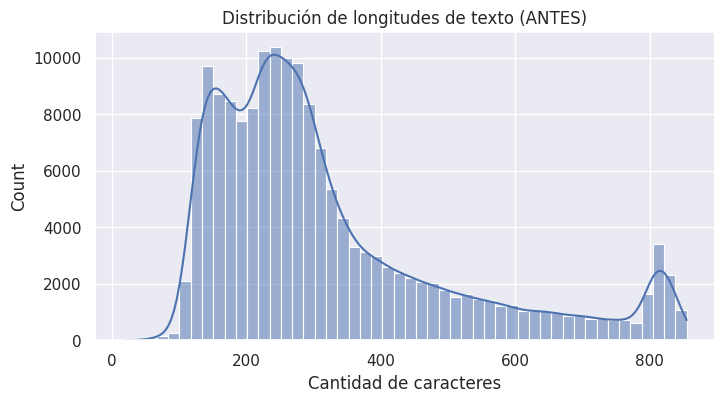

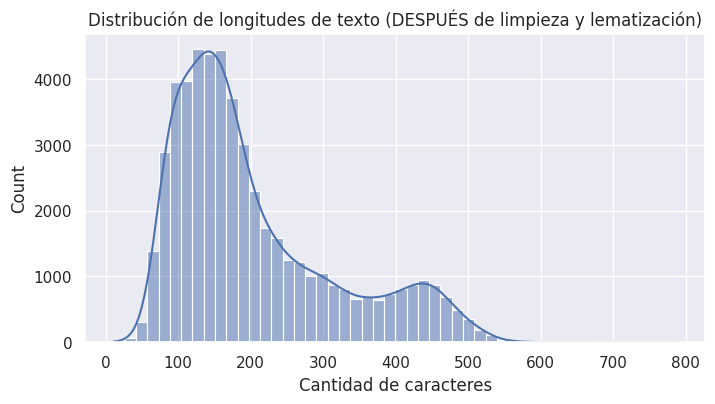

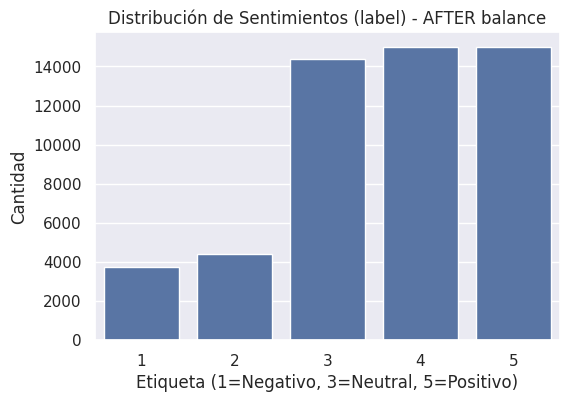

In [23]:
print("\n=== Aplicando limpieza y lematización... ===")
df_train_bal["texto_limpio"] = df_train_bal["text"].apply(limpiar_y_lematizar)

# === Ejemplos de transformación ===
print("\n=== Ejemplos de texto original vs. texto_limpio ===")
for i in range(3):
    print(f"Texto original [{i}]:", df_train_bal.loc[i, "text"])
    print(f"Texto limpio   [{i}]:", df_train_bal.loc[i, "texto_limpio"])
    print("--------------------------------------------------")

# === Validar que no hay NaNs ===
na_count = df_train_bal["texto_limpio"].isnull().sum()
print(f"\nNaNs en 'texto_limpio': {na_count}")
assert na_count == 0, "Hay textos vacíos después de la limpieza"

# === Longitud del texto limpio ===
df_train_bal["long_texto_limpio"] = df_train_bal["texto_limpio"].apply(len)

# 1. Longitud original (antes de limpiar)
plt.figure(figsize=(8, 4))
sns.histplot(df_train["text"].apply(len), bins=50, kde=True)
plt.title("Distribución de longitudes de texto (ANTES)")
plt.xlabel("Cantidad de caracteres")
plt.show()

# 2. Longitud después de limpieza
plt.figure(figsize=(8, 4))
sns.histplot(df_train_bal["long_texto_limpio"], bins=50, kde=True)
plt.title("Distribución de longitudes de texto (DESPUÉS de limpieza y lematización)")
plt.xlabel("Cantidad de caracteres")
plt.show()

# 3. Distribución de clases final
plt.figure(figsize=(6, 4))
sns.countplot(data=df_train_bal, x="label")
plt.title("Distribución de Sentimientos (label) - AFTER balance")
plt.xlabel("Etiqueta (1=Negativo, 3=Neutral, 5=Positivo)")
plt.ylabel("Cantidad")
plt.show()

5. Dividir en entrenamiento y validación

In [7]:
X = df_train_bal["texto_limpio"]
y = df_train_bal["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

print("\nDistribución en entrenamiento:")
print(y_train.value_counts(normalize=True).round(3))

print("\nDistribución en validación:")
print(y_val.value_counts(normalize=True).round(3))



Distribución en entrenamiento:
label
4    0.286
5    0.286
3    0.274
2    0.084
1    0.071
Name: proportion, dtype: float64

Distribución en validación:
label
5    0.286
4    0.286
3    0.274
2    0.084
1    0.071
Name: proportion, dtype: float64


6. Vectorizar (TF-IDF)

In [15]:
# ✅ Punto 6: Embeddings con BERT (reemplaza TF-IDF)
from sentence_transformers import SentenceTransformer

# Cargar modelo BERT preentrenado
print("\n== Cargando modelo BERT (MiniLM)==")
bert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Generar embeddings para set de entrenamiento y validación
print("\n== Generando embeddings para entrenamiento ==")
X_train_embed = bert_model.encode(X_train.tolist(), show_progress_bar=True)

print("\n== Generando embeddings para validación ==")
X_val_embed = bert_model.encode(X_val.tolist(), show_progress_bar=True)


== Cargando modelo BERT (MiniLM)==


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


== Generando embeddings para entrenamiento ==


Batches:   0%|          | 0/1150 [00:00<?, ?it/s]


== Generando embeddings para validación ==


Batches:   0%|          | 0/493 [00:00<?, ?it/s]

7. Entrenar modelo (LogisticRegression)


== Entrenando red neuronal con Keras ==


/home/carizac/documnetos/proyecto_nlp/venv_nlp/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3772 - loss: 1.3703 - val_accuracy: 0.4459 - val_loss: 1.2335
Epoch 2/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4495 - loss: 1.2250 - val_accuracy: 0.4539 - val_loss: 1.2165
Epoch 3/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4724 - loss: 1.1961 - val_accuracy: 0.4623 - val_loss: 1.1930
Epoch 4/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4725 - loss: 1.1758 - val_accuracy: 0.4645 - val_loss: 1.1907
Epoch 5/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4859 - loss: 1.1548 - val_accuracy: 0.4694 - val_loss: 1.1832
Epoch 6/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5071 - loss: 1.1325 - val_accuracy: 0.4721 - val_loss: 1.1715
Epoch 7/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5104 - loss: 1.1125 - val_accuracy: 0.4728 - val_loss: 1.1696
Epoch 8/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5200 - loss: 1.0958 - val_acc

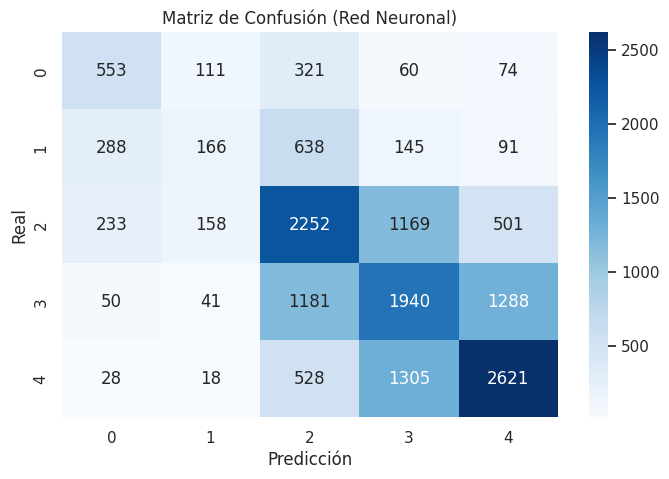

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
print("\n== Entrenando red neuronal con Keras ==")

# 1. Codificar las etiquetas a valores entre 0 y 4
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)

# 2. One-hot encoding para entrenamiento
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat = to_categorical(y_val_enc, num_classes=num_classes)

# 3. Definir la arquitectura de la red
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_embed.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# 4. Compilar
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# 5. Entrenar
history = model.fit(
    X_train_embed, y_train_cat,
    validation_data=(X_val_embed, y_val_cat),
    epochs=10,
    batch_size=64,
    verbose=1
)

# 6. Evaluar
print("\n== Evaluación de la red neuronal ==")
y_pred_probs = model.predict(X_val_embed)
y_pred_classes = y_pred_probs.argmax(axis=1)

# 7. Reporte y matriz de confusión
print(classification_report(y_val_enc, y_pred_classes, digits=4))

cm = confusion_matrix(y_val_enc, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión (Red Neuronal)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

9: Evaluación del modelo final sobre el set de prueba

In [29]:
print("\n== Punto 9: Evaluación sobre datos reales de prueba ==")

# 1. Cargar el set de prueba real
df_test = pd.read_parquet("/home/carizac/documnetos/proyecto_nlp/test-00000-of-00001-9cc7bacfd2a73ac7.parquet")
print("Tamaño df_test:", df_test.shape)

# 2. Aplicar limpieza y lematización
print("\nLimpiando y lematizando textos del set de prueba...")
df_test["texto_limpio"] = df_test["text"].apply(limpiar_y_lematizar)

# Validación
assert df_test["texto_limpio"].isnull().sum() == 0, "Error: hay textos vacíos después de limpieza"
print("✔️ Textos limpios correctamente.")



== Punto 9: Evaluación sobre datos reales de prueba ==
Tamaño df_test: (75510, 2)

Limpiando y lematizando textos del set de prueba...
✔️ Textos limpios correctamente.


In [30]:
print("\n🔍 Generando embeddings BERT para test...")
X_test_embed = bert_model.encode(df_test["texto_limpio"].tolist(), show_progress_bar=True)
print("✔️ Embeddings generados.")



🔍 Generando embeddings BERT para test...


Batches:   0%|          | 0/2360 [00:00<?, ?it/s]

✔️ Embeddings generados.



📊 Evaluando con etiquetas reales...
⚠️ Hay etiquetas desconocidas en test: {np.int64(5)}
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.1948    0.0958    0.1285      1722
           2     0.1039    0.4696    0.1701      2119
           3     0.1722    0.2607    0.2074      6395
           4     0.8438    0.2866    0.4278     17995

    accuracy                         0.2828     28231
   macro avg     0.2629    0.2225    0.1868     28231
weighted avg     0.5965    0.2828    0.3403     28231



/home/carizac/documnetos/proyecto_nlp/venv_nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carizac/documnetos/proyecto_nlp/venv_nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carizac/documnetos/proyecto_nlp/venv_nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

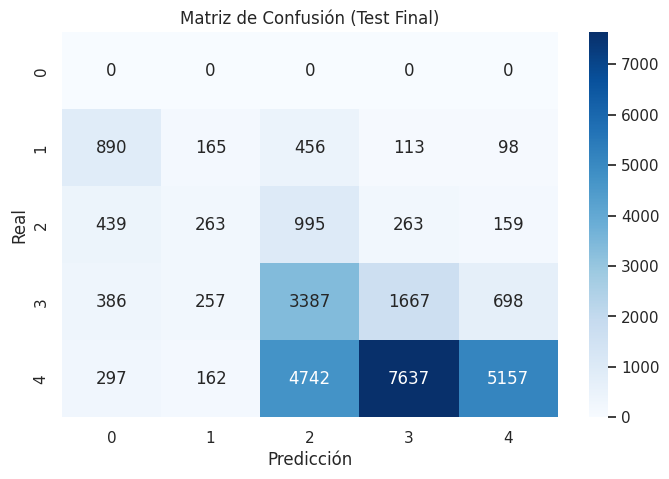

In [35]:
# 6. Si tienes etiquetas reales
if "label" in df_test.columns:
    print("\n📊 Evaluando con etiquetas reales...")

    # Verificar si hay etiquetas nuevas no vistas por el modelo
    etiquetas_nuevas = set(df_test["label"].unique()) - set(label_encoder.classes_)

    if etiquetas_nuevas:
        print(f"⚠️ Hay etiquetas desconocidas en test: {etiquetas_nuevas}")
        # Filtrar etiquetas desconocidas
        etiquetas_validas = set(label_encoder.classes_)
        df_test = df_test[df_test["label"].isin(etiquetas_validas)].copy()
        y_test_pred = y_test_pred[df_test.index]

    # Evaluación final
    y_test_true_enc = label_encoder.transform(df_test["label"])
    print(classification_report(y_test_true_enc, y_test_pred, digits=4))

    cm = confusion_matrix(y_test_true_enc, y_test_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusión (Test Final)")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

